In [ ]:
!git clone https://github.com/kairess/fingerprint_recognition.git
%cd fingerprint_recognition

Cloning into 'fingerprint_recognition'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Receiving objects: 100% (37/37), 210.88 MiB | 12.76 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (14/14), done.
/content/fingerprint_recognition


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

# **Tải dataset**

(6000, 90, 90, 1) (6000, 4)


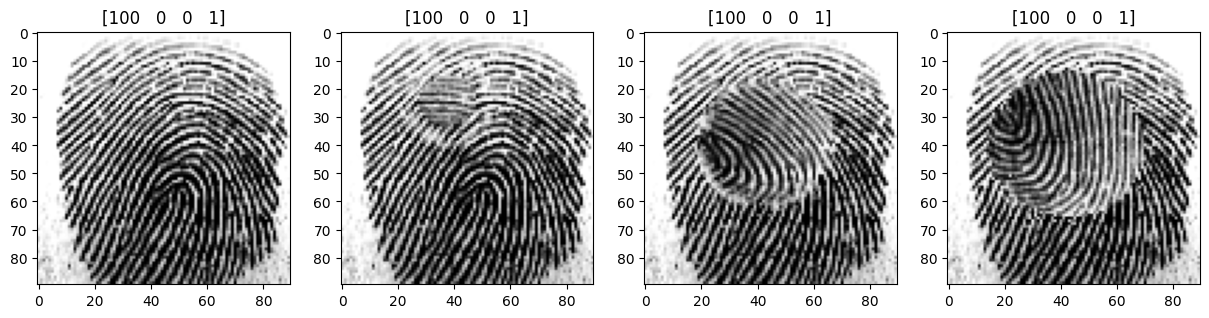

In [ ]:
#Dữ liệu thực tế: các hình ảnh dấu vân tay còn nguyên vẹn, rõ ràng
x_real = np.load('dataset/x_real.npz')['data']
y_real = np.load('dataset/y_real.npy')
#Dữ liệu dễ nhận ra: các hình ảnh dấu vân tay bị biến dạng một chút
x_easy = np.load('dataset/x_easy.npz')['data']
y_easy = np.load('dataset/y_easy.npy')
#Dữ liệu có độ khó trung bình: Các hình ảnh dấu vân tay bị biến dạng nhiều hơn
x_medium = np.load('dataset/x_medium.npz')['data']
y_medium = np.load('dataset/y_medium.npy')
#Dữ liệu khó bao gồm các vân tay bị mờ, biến dạng hoặc khó nhận diện: Các hình ảnh dấu vân tay bị biến dạng phần lớn, khó nhận rõ
x_hard = np.load('dataset/x_hard.npz')['data']
y_hard = np.load('dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(str(y_real[0]))  # Ensure y_real[0] is a string
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(str(y_easy[0]))  # Ensure y_easy[0] is a string
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(str(y_medium[0]))  # Ensure y_medium[0] is a string
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(str(y_hard[0]))  # Ensure y_hard[0] is a string
plt.imshow(x_hard[0].squeeze(), cmap='gray')

# Train Test Split

In [ ]:
#Kết hợp dữ liệu
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0) #Tất cả dữ liệu có vấn đề được trộn lại với nhau
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)
#Chia dữ liệu thành tập train và test theo tỉ lệ 10% là test 90% là train
x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


# Tăng cường dữ liệu

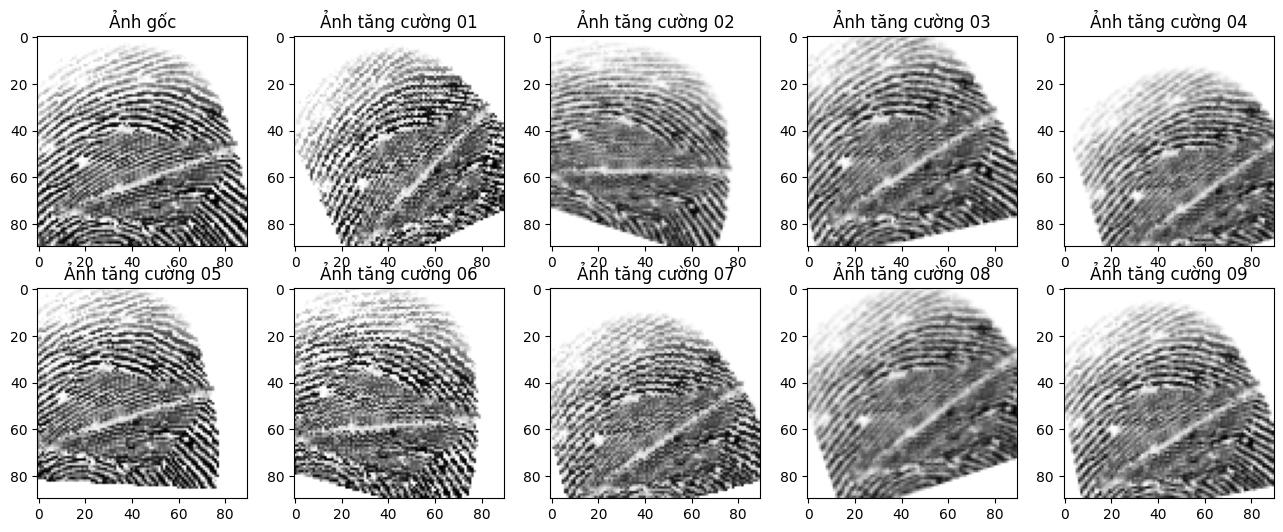

In [ ]:
augs = [x_data[40000]] * 9 #Đây là ảnh sẽ được tăng cường

seq = iaa.Sequential([
    # Làm mờ hình ảnh với giá trị sigma từ 0 đến 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # Phóng to/thu nhỏ hình ảnh từ 90% đến 110% theo từng trục
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # Dịch chuyển hình ảnh từ -10% đến +10% theo từng trục
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # Xoay hình ảnh từ -30 đến +30 độ
        rotate=(-30, 30),
        # Sử dụng nội suy gần nhất hoặc nội suy song tuyến (nhanh)
        order=[0, 1],
        # Nếu chế độ là hằng số, sử dụng giá trị từ 0 đến 255
        cval=255
    )
], random_order=True)
#Áp dụng lên ảnh
augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('Ảnh gốc')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('Ảnh tăng cường %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# Bảng tra cứu dấu vân tay dựa trên nhãn

In [ ]:
#Tạo 1 hàm giúp tra cứu nhanh vị trí label mà không cần duyệt qua tất cả mảng y_real
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

# Data Generator

In [ ]:
#Xáo trộn vằ biến đổi dữ liệu
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Khởi tạo'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Số lượng batch mỗi epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Tạo một batch dữ liệu'
        # Tạo các chỉ số của batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]

        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)

        # Augmentation (tăng cường dữ liệu)
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)

        # Chọn ảnh khớp (label 1.0) và không khớp (label 0.0) và đưa vào batch
        # Ảnh khớp phải có tất cả các trường giống nhau, [subject_id(3), gender(1), left_right(1), finger(1)], ví dụ) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # Đưa vào ảnh khớp
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # Đưa vào ảnh không khớp
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)


In [ ]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

# Create Model

In [ ]:
#Tạo model
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 22, 22, 32)           9568      ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 subtract (Subtract)         (None, 22, 22, 32)           0         ['model[0][0]',         

# Huấn luyện

In [ ]:
history = model.fit_generator(train_gen, epochs=15, validation_data=val_gen)

<ipython-input-10-8a04cad3d095>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=15, validation_data=val_gen)


Epoch 1/15
1385/1385 [==============================] - 98s 63ms/step - loss: 0.2427 - acc: 0.8955 - val_loss: 0.0970 - val_acc: 0.9561
Epoch 2/15
1385/1385 [==============================] - 54s 39ms/step - loss: 0.1427 - acc: 0.9447 - val_loss: 0.0545 - val_acc: 0.9773
Epoch 3/15
1385/1385 [==============================] - 66s 48ms/step - loss: 0.1145 - acc: 0.9569 - val_loss: 0.0229 - val_acc: 0.9912
Epoch 4/15
1385/1385 [==============================] - 57s 41ms/step - loss: 0.0909 - acc: 0.9654 - val_loss: 0.0319 - val_acc: 0.9865
Epoch 5/15
1385/1385 [==============================] - 56s 40ms/step - loss: 0.0808 - acc: 0.9701 - val_loss: 0.0116 - val_acc: 0.9951
Epoch 6/15
1385/1385 [==============================] - 53s 38ms/step - loss: 0.0713 - acc: 0.9739 - val_loss: 0.0180 - val_acc: 0.9920
Epoch 7/15
1385/1385 [==============================] - 55s 39ms/step - loss: 0.0651 - acc: 0.9758 - val_loss: 0.0114 - val_acc: 0.9955
Epoch 8/15
1385/1385 [==========================

# Đánh giá

In [ ]:
count=0# Dùng để đánh giá xem ở trong x_val có bao nhiêu tấm ảnh nằm trong x_real
for i in range(0, len(x_val)-1):#Chạy hết tập dữ liệu dấu vân tay trong tập val
  idx = i

  img = x_val[idx]    #Ảnh 1 để so sánh
  label = label_val[idx]

  img = seq.augment_image(img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.
  # Tìm kiếm ảnh vân tay giống nhau dựa trên label
  match_key = label.astype(str)
  match_key = ''.join(match_key).zfill(6)

  rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255. #Tìm được ảnh 2
  ry = y_real[label_real_dict[match_key]]

  pred_rx = model.predict([img, rx]) #SO sánh ảnh 1 và ảnh 2. Do 2 ảnh chung label nên chắc chắn chúng phải giống nhau, nếu khác nhau thì model tính sai
  if pred_rx>0.8: #Nếu độ chính xác cao hơn 0.8 thì coi như model đúng
    count=count+1
print("Độ chính xác của model là:", count/len(x_val))

1/1 [==============================] - 0s 27ms/step
Độ chính xác của model là: 0.9715851430891008


In [ ]:
print("Độ chính xác của model là:", count/len(x_val))

Độ chính xác của model là: 0.9715851430891008


# Test trực quan

Test case 1: real vs easy
1/1 [==============================] - 0s 19ms/step
not same


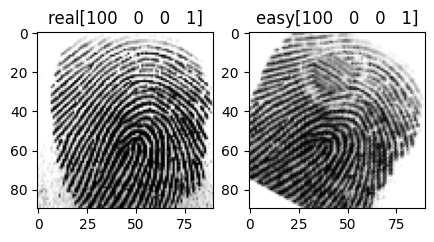

In [ ]:
easy_img = x_easy[0]#Ảnh biến dạng nhẹ
easy_label = y_easy[0]

easy_img = seq.augment_image(easy_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

real_img = x_real[0].reshape((1, 90, 90, 1)).astype(np.float32) / 255. # Ảnh không biến dạng
real_label = y_real[0]

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title("real" + str(real_label))
plt.imshow(real_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("easy" + str(easy_label))
plt.imshow(easy_img.squeeze(), cmap='gray')

print("Test case 1: real vs easy")
pre1 = model.predict([real_img,easy_img])
if pre1 > 0.8:
      print("same")
else:
      print("not same")

Test case 2: real vs med
1/1 [==============================] - 0s 63ms/step
same


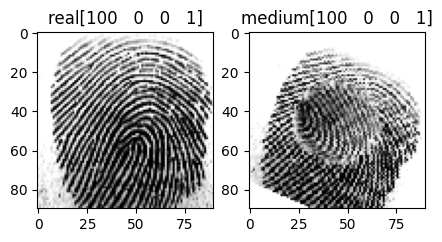

In [ ]:
med_img = x_medium[0]#Ảnh biến dạng vừa
med_label = y_medium[0]

med_img = seq.augment_image(med_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title("real" + str(real_label))
plt.imshow(real_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("medium" + str(med_label))
plt.imshow(med_img.squeeze(), cmap='gray')

print("Test case 2: real vs med")
pre2 = model.predict([real_img,med_img])
if pre2 > 0.8:
      print("same")
else:
      print("not same")

Test case 3: real vs hard
1/1 [==============================] - 0s 21ms/step
not same


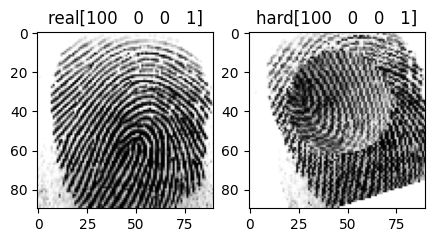

In [ ]:
hard_img = x_hard[0]#Ảnh biến dạng vừa
hard_label = y_hard[0]

hard_img = seq.augment_image(hard_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title("real" + str(real_label))
plt.imshow(real_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("hard" + str(hard_label))
plt.imshow(hard_img.squeeze(), cmap='gray')

print("Test case 3: real vs hard")
pre3 = model.predict([real_img,hard_img])
if pre3 > 0.8:
      print("same")
else:
      print("not same")

Test case 4: med vs hard
1/1 [==============================] - 0s 34ms/step
same


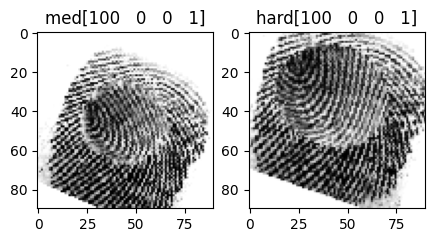

In [ ]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title("med" + str(med_label))
plt.imshow(med_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("hard" + str(hard_label))
plt.imshow(hard_img.squeeze(), cmap='gray')

print("Test case 4: med vs hard")
pre3 = model.predict([med_img,real_img])
if pre3 > 0.8:
      print("same")
else:
      print("not same")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/My Drive/Fingerprint')